# Dont' use features that require transform to res variables with celmech in tseries. Almost as good as models that include them

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import dill
import sys
sys.path.append('../spock/')
from modelfitting import train_test_split, ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '../training_data/'
dset = 'resonant/'
Norbits = 1e4
Nout = 80
featureargs = (Norbits, Nout) # params to pass feature function
featurefolder = 'additional_featuresNorbits{0:.1f}Nout{1}trio/'.format(Norbits, Nout)
trainingdatafolder = datapath+dset+featurefolder

In [3]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 50),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 100,
                            max_depth = params['max_depth'], 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            colsample_bytree = params['colsample_bytree'],
                            learning_rate = params['learning_rate'], seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

# MEGNO

In [4]:
features = ['MEGNO']

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [5]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.8610182399999999                                  
ERROR                                               
0.0017834029761300233                               
SCORE:                                                                        
0.85679576                                                                    
ERROR                                                                         
0.0015776938462936218                                                         
SCORE:                                                                        
0.81174864                                                                    
ERROR                                                                         
0.0024175672062279685                                                         
SCORE:                                                                        
0.8587014                                                                    

SCORE:                                                                         
0.86040622                                                                     
ERROR                                                                          
0.0016335648461075609                                                          
SCORE:                                                                         
0.8572889800000001                                                             
ERROR                                                                          
0.0012821500540372824                                                          
SCORE:                                                                         
0.8614409199999999                                                             
ERROR                                                                          
0.0018857533309148417                                                          
SCORE:                                  

In [6]:
best

{'x_learning_rate': 0.16478451158277696,
 'x_max_depth': 6,
 'x_min_child': 7.0,
 'x_pos_weight': 26.75274087483514,
 'x_subsample': 0.8805958793839032,
 'x_tree_colsample': 0.8622179398728552}

# Would have to set num_boost_round=100 to see the same CV score as in our final fitted model

We're setting n_estimators=100 in model, which is the equivalent of num_boost_round in CV, so if we use the default in CV (10), we will get slightly lower powerformance

In [7]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.86098+0.00080	test-auc:0.85821+0.00241
[1]	train-auc:0.86226+0.00094	test-auc:0.85936+0.00234
[2]	train-auc:0.86281+0.00086	test-auc:0.85987+0.00218
[3]	train-auc:0.86325+0.00075	test-auc:0.86014+0.00206
[4]	train-auc:0.86358+0.00059	test-auc:0.86050+0.00199
[5]	train-auc:0.86404+0.00063	test-auc:0.86079+0.00178
[6]	train-auc:0.86427+0.00061	test-auc:0.86099+0.00169
[7]	train-auc:0.86453+0.00045	test-auc:0.86103+0.00169
[8]	train-auc:0.86464+0.00040	test-auc:0.86097+0.00169
[9]	train-auc:0.86487+0.00047	test-auc:0.86099+0.00175


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8622179398728552, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.16478451158277696, max_delta_step=0, max_depth=6,
              min_child_weight=7.0, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=26.75274087483514,
              subsample=0.8805958793839032, tree_method=None,
              validate_parameters=False, verbosity=None)

In [8]:
model.save_model(datapath+'../spock/models/megno.json')

Text(0.5, 1.0, 'ROC curve (AUC = 0.867)')

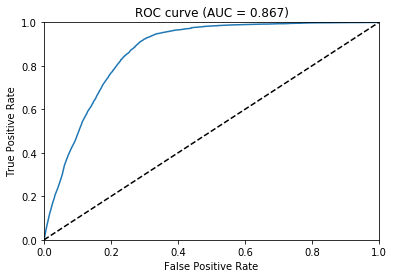

In [8]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [10]:
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

Threshold 1.9799878597259521, TPR = 0.0, FPR = 0.0
Threshold 0.9760366082191467, TPR = 0.19297583081570996, FPR = 0.030551886521564348
Threshold 0.9728579521179199, TPR = 0.34233383685800606, FPR = 0.06075920289438925
Threshold 0.9698216319084167, TPR = 0.4074773413897281, FPR = 0.07747085510825245
Threshold 0.9674466252326965, TPR = 0.4520392749244713, FPR = 0.09142594613220008
Threshold 0.966060221195221, TPR = 0.5228474320241692, FPR = 0.10945845058289784
Threshold 0.963981568813324, TPR = 0.5358761329305136, FPR = 0.1126170102796761
Threshold 0.9618535041809082, TPR = 0.5895015105740181, FPR = 0.12996037443289496
Threshold 0.9598618745803833, TPR = 0.6199018126888217, FPR = 0.14259461322000805
Threshold 0.9580060839653015, TPR = 0.6478474320241692, FPR = 0.1531040027565612
Threshold 0.9552502036094666, TPR = 0.6801359516616314, FPR = 0.1639579624418538
Threshold 0.9534006118774414, TPR = 0.6888217522658611, FPR = 0.16694423706426234
Threshold 0.9527114629745483, TPR = 0.70128398791

# AMD

In [11]:
features = ['AMDtriofracnear', 'AMDtriofracfar']

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [12]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.71237158                                          
ERROR                                               
0.009403267425608892                                
SCORE:                                                               
0.70446478                                                           
ERROR                                                                
0.007589252082068872                                                 
SCORE:                                                               
0.6833743000000001                                                   
ERROR                                                                
0.011422226193559471                                                 
SCORE:                                                               
0.7143895600000001                                                   
ERROR                                                                
0.0090016874043540

ERROR                                                                         
0.009009767781654038                                                          
SCORE:                                                                        
0.71413578                                                                    
ERROR                                                                         
0.00903966383669607                                                           
SCORE:                                                                        
0.7137333800000001                                                            
ERROR                                                                         
0.009324060441165103                                                          
SCORE:                                                                        
0.7130606800000001                                                            
ERROR                                               

In [13]:
best

{'x_learning_rate': 0.15620694056130713,
 'x_max_depth': 4,
 'x_min_child': 7.0,
 'x_pos_weight': 28.745055109175368,
 'x_subsample': 0.9122057639582176,
 'x_tree_colsample': 0.7879523988270615}

In [14]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.69099+0.00073	test-auc:0.68886+0.00176
[1]	train-auc:0.71362+0.01782	test-auc:0.71074+0.01860
[2]	train-auc:0.71702+0.01248	test-auc:0.71377+0.01141
[3]	train-auc:0.71857+0.00362	test-auc:0.71427+0.00392
[4]	train-auc:0.71892+0.00874	test-auc:0.71486+0.00920
[5]	train-auc:0.72017+0.00940	test-auc:0.71654+0.00853
[6]	train-auc:0.72083+0.01160	test-auc:0.71710+0.01039
[7]	train-auc:0.72167+0.01141	test-auc:0.71739+0.01047
[8]	train-auc:0.72216+0.01313	test-auc:0.71793+0.01209
[9]	train-auc:0.72306+0.01408	test-auc:0.71869+0.01317


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7879523988270615, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.15620694056130713, max_delta_step=0, max_depth=4,
              min_child_weight=7.0, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=28.745055109175368,
              subsample=0.9122057639582176, tree_method=None,
              validate_parameters=False, verbosity=None)

In [15]:
model.save_model(datapath+'../spock/models/AMD.json')

Text(0.5, 1.0, 'ROC curve (AUC = 0.724)')

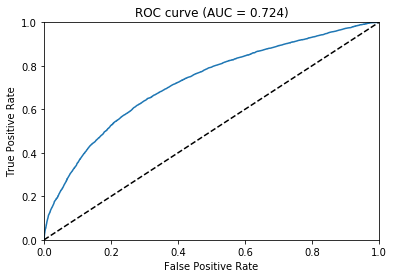

In [17]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

# Hill

In [18]:
features = ['betanear', 'betafar']

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [19]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.69321332                                          
ERROR                                               
0.015087209525725755                                
SCORE:                                                               
0.68330978                                                           
ERROR                                                                
0.013957966471470348                                                 
SCORE:                                                               
0.6717651200000001                                                   
ERROR                                                                
0.012607754633259485                                                 
SCORE:                                                               
0.6968506800000001                                                   
ERROR                                                                
0.0140691605654647

0.69582784                                                                     
ERROR                                                                          
0.01496686331884407                                                            
SCORE:                                                                         
0.6956583999999999                                                             
ERROR                                                                          
0.014802441325867385                                                           
SCORE:                                                                         
0.69678922                                                                     
ERROR                                                                          
0.014059563012360832                                                           
SCORE:                                                                         
0.696877                                

In [20]:
best

{'x_learning_rate': 0.1988830373151137,
 'x_max_depth': 3,
 'x_min_child': 3.0,
 'x_pos_weight': 27.042872111520865,
 'x_subsample': 0.8007849462574025,
 'x_tree_colsample': 0.7267696531078781}

In [21]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.63287+0.00066	test-auc:0.63154+0.00181
[1]	train-auc:0.68467+0.04187	test-auc:0.68339+0.03981
[2]	train-auc:0.69994+0.03264	test-auc:0.69851+0.03105
[3]	train-auc:0.71149+0.00226	test-auc:0.70908+0.00228
[4]	train-auc:0.71248+0.00540	test-auc:0.70972+0.00581
[5]	train-auc:0.71441+0.00781	test-auc:0.71192+0.00836
[6]	train-auc:0.71342+0.00994	test-auc:0.71081+0.01015
[7]	train-auc:0.71583+0.00801	test-auc:0.71308+0.00900
[8]	train-auc:0.71537+0.01001	test-auc:0.71300+0.01083
[9]	train-auc:0.71666+0.01034	test-auc:0.71419+0.01113


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7267696531078781, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1988830373151137, max_delta_step=0, max_depth=3,
              min_child_weight=3.0, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=27.042872111520865,
              subsample=0.8007849462574025, tree_method=None,
              validate_parameters=False, verbosity=None)

In [22]:
model.save_model(datapath+'../spock/models/hill.json')

Text(0.5, 1.0, 'ROC curve (AUC = 0.723)')

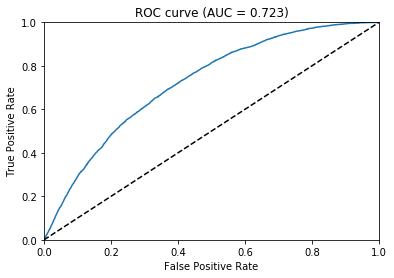

In [24]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

# N-body

In [25]:
datapath = '../training_data/'
dset = 'resonant/'
featurefolder = 'shadowtimes/'
trainingdatafolder = datapath+dset+featurefolder
features=None

In [26]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

In [27]:
shadowstable = trainX['shadow_instability_time'] > 8.99e8

3% had stability in shadow integration disagree with nominal integration

In [28]:
(trainY != shadowstable).sum()/trainY.shape[0]

0.016084285619922055

In [29]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.69321332                                          
ERROR                                               
0.015087209525725755                                
SCORE:                                                               
0.68330978                                                           
ERROR                                                                
0.013957966471470348                                                 
SCORE:                                                               
0.6717651200000001                                                   
ERROR                                                                
0.012607754633259485                                                 
SCORE:                                                               
0.6968506800000001                                                   
ERROR                                                                
0.0140691605654647

0.69582784                                                                     
ERROR                                                                          
0.01496686331884407                                                            
SCORE:                                                                         
0.6956583999999999                                                             
ERROR                                                                          
0.014802441325867385                                                           
SCORE:                                                                         
0.69678922                                                                     
ERROR                                                                          
0.014059563012360832                                                           
SCORE:                                                                         
0.696877                                

In [30]:
best

{'x_learning_rate': 0.1988830373151137,
 'x_max_depth': 3,
 'x_min_child': 3.0,
 'x_pos_weight': 27.042872111520865,
 'x_subsample': 0.8007849462574025,
 'x_tree_colsample': 0.7267696531078781}

In [31]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

[0]	train-auc:0.63287+0.00066	test-auc:0.63154+0.00181
[1]	train-auc:0.68467+0.04187	test-auc:0.68339+0.03981
[2]	train-auc:0.69994+0.03264	test-auc:0.69851+0.03105
[3]	train-auc:0.71149+0.00226	test-auc:0.70908+0.00228
[4]	train-auc:0.71248+0.00540	test-auc:0.70972+0.00581
[5]	train-auc:0.71441+0.00781	test-auc:0.71192+0.00836
[6]	train-auc:0.71342+0.00994	test-auc:0.71081+0.01015
[7]	train-auc:0.71583+0.00801	test-auc:0.71308+0.00900
[8]	train-auc:0.71537+0.01001	test-auc:0.71300+0.01083
[9]	train-auc:0.71666+0.01034	test-auc:0.71419+0.01113


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7267696531078781, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1988830373151137, max_delta_step=0, max_depth=3,
              min_child_weight=3.0, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=27.042872111520865,
              subsample=0.8007849462574025, tree_method=None,
              validate_parameters=False, verbosity=None)

In [32]:
model.save_model(datapath+'../spock/models/nbody.json')

Text(0.5, 1.0, 'ROC curve (AUC = 0.991)')

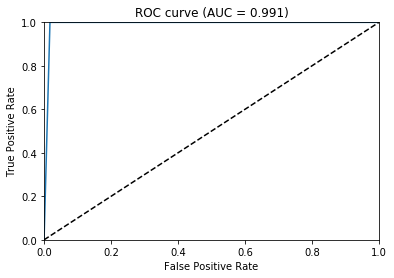

In [33]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))